# Demonstration of **oceanliner**: OSSEs for SWOT in situ campaigns

This notebook enables a user to select a region from one of the 10 [Adopt-a-Crossover](https://www.swot-adac.org/) sites and specify a sampling trajectory (e.g., the path of an ocean glider or a ship-based underway CTD), and then does the following:
* download llc4320 data to the local machine
* compute steric height and potential vorticity 
* interpolate model fields in space/time over the trajectory
* return set of subsampled variables 
* store and plot outputs, including "true" and "subsampled" steric height 

### User inputs:
* **RegionName**: name of region (corresponding to filename) - options are WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST MarmaraSea  LabradorSea  CapeBasin
* **start_date**, **ndays**: specify date range as start date & number of days.
* **SAMPLING_STRATEGY** : select whether you want to sample the model using a simulated glider track (`sim_glider`), a simulated underway ctd (`sim_uctd`), a mooring (`mooring`), or a user-specified trajectory (`trajectory_file`), in which case **trajectory_file** must also be specified
* **PATTERN**: survey pattern -- can be `lawnmower` or `back-forth`
* **datadir** : directory where data files are stored



### Future developments to include:
* implement other sampling platforms (surface vessels, drifters)
* cloud version
* derivation of other variables of interest
* subsample simulated SWOT data
* piping output into optimal interpolation software
* implement other models
* efficiency improvements



Code to download data from PO.DAAC adapted from [this demo](https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb) by Jinbo Wang & Jack McNelis (JPL) 


In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import time
import sys
import os

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Other third-party packages
import netCDF4 as nc4

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid
import xgcm.grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.dates as mdates

# osse tools package
# del sys.modules['osse_tools']  # uncomment if troubleshooting osse_tools
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp


In [2]:

# # dask
# import dask
# from dask.distributed import Client


# set up dask client
# client = Client()
# client

In [3]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
# NOTE: ndays must be >1 
ndays = 20 # crashes for more than ~20 days :(


# directory where data files are stored
datadir = '/data3/llc4320/' + RegionName + '/'                      # input model data are here
outputdir = '/data3/adac/osse_output/' + RegionName + '/'           # interpolated data stored here
figdir = '/data2/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures

SAVE_FIGURES = False # True or False
SAVE_PRELIMINARY = True # True: save preliminary along-track data. This takes more space but is faster and less prone to crashing.
# LOAD_PRELIMINARY = True # TODO: if preliminary data files exist, load these

# optional details for sampling (if not specified, reasonable defaults will be used)
# NOTE!! mooring and sim_mooring are different:
#    sim_mooring treats the mooring datapoints like a glider, 
#    whereas mooring interpolates directly to the mooring grid and should be faster
sampling_details = {
#     'SAMPLING_STRATEGY' : 'sim_glider', 
   'SAMPLING_STRATEGY' : 'trajectory_file', # options: sim_glider, sim_uctd or trajectory_file.add:  ASV
#     'SAMPLING_STRATEGY' : 'mooring', # options: sim_glider, sim_uctd, sim_mooring or trajectory_file.add: ASV. 
#     'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
#     'zmooring_TS' : list(range(-10,-1000,-10)) # instrument depths for moorings. T/S and U/V are the same.
    'hspeed' : 0.25,  # platform horizontal speed in m/s (for glider, uCTD)
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s  (for glider, uCTD)
   'trajectory_file' : '../data/survey_trajectory_ACC_SMST_glider.nc', # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'reverse', # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
    'DERIVED_VARIABLES' : True, # specify whether or not to process the derived variables (steric height, rotated velocity, vorticity) - slower and takes significant to derive/save the stored variables
    'SAVE_PRELIMINARY' : SAVE_PRELIMINARY, # flag to save along-track data or not
    'start_date' : start_date,
    'ndays' : ndays
}


#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. 

In [4]:
# uncomment the following two lines if troubleshooting osse_tools
# del sys.modules['osse_tools']  
# from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp


# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)


# derive & save new files with steric height & vorticity
if sampling_details['DERIVED_VARIABLES']:
    compute_derived_fields(RegionName, datadir, start_date, ndays)

#### Load all model data files. 
If `DERIVED_VARIABLES = True`, do *not* load U, V, or oceTAUX, oceTAUY as we will replace these with transformed versions .

Note that if `DERIVED_VARIABLES = False`, the vector variables U,V, TAUX and TAUY are in the reference frame of the model and must be rotated.

In [5]:
%%time
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

# chunk size ... aiming for ~100 MB chunks
# these chunks seem to work OK for up to ~20 day simulations, but more 
# testing is needed to figure out optimal parameters for longer simulations
tchunk = None
xchunk = None
ychunk = None

# drop the vector variables if loading derived variables because we are going to load the rotated ones in the next cell
if sampling_details['DERIVED_VARIABLES']:
    drop_variables={'U', 'V', 'oceTAUX', 'oceTAUY'}
else:
    drop_variables={}

# ds = xr.open_mfdataset(target_files, parallel=True, 
#                        drop_variables=drop_variables,
#                       chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})

# NO DASK:

ds = xr.open_mfdataset(target_files, 
                       drop_variables=drop_variables)


# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)


CPU times: user 1.51 s, sys: 102 ms, total: 1.62 s
Wall time: 5.79 s


In [6]:
%%time
# load the corresponding derived fields (includes steric height, vorticity, and transformed vector variables for current and wind stress)
if sampling_details['DERIVED_VARIABLES']:
    derivedir = datadir + 'derived/'
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    dsd = xr.open_mfdataset(derived_files, parallel=True, chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})
    
    # merge the derived and raw data
    ds = ds.merge(dsd)
    # rename the transformed vector variables to their original names
    ds = ds.rename_vars({'U_transformed':'U', 'V_transformed':'V', 
                         'oceTAUX_transformed':'oceTAUX', 'oceTAUY_transformed':'oceTAUY'})


# drop a bunch of other vars we don't actually use - can comment this out if these are wanted
ds = ds.drop_vars({'DXV','DYU', 'DXC','DXG', 'DYC','DYG', 'XC_bnds', 'YC_bnds', 'Zp1', 'Zu','Zl','Z_bnds', 'nb'})
ds

CPU times: user 964 ms, sys: 205 ms, total: 1.17 s
Wall time: 2 s


<xarray.Dataset>
Dimensions:             (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84,
                         k_l: 84, k_p1: 85, time: 480, zref: 27)
Coordinates:
  * j_g                 (j_g) float32 0.0 1.0 2.0 3.0 ... 346.0 347.0 348.0
  * i                   (i) float32 0.0 1.0 2.0 3.0 ... 188.0 189.0 190.0 191.0
  * i_g                 (i_g) float32 0.0 1.0 2.0 3.0 ... 189.0 190.0 191.0
  * j                   (j) float32 0.0 1.0 2.0 3.0 ... 345.0 346.0 347.0 348.0
  * k                   (k) int32 0 1 2 3 4 5 6 7 8 ... 76 77 78 79 80 81 82 83
  * k_u                 (k_u) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
  * k_l                 (k_l) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
  * k_p1                (k_p1) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * time                (time) datetime64[ns] 2012-01-01 ... 2012-01-20T23:00:00
  * zref                (zref) float64 0.0 5.0 10.0 ... 1.5e+03 1.75e+03 2e+03
    yav                 float64 -55.5
    xav                 float64 152.5
Data variables: (12/28)
    XC                  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    YC                  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    Depth               (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    AngleSN             (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    AngleCS             (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    XG                  (time, j_g, i_g) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    ...                  ...
    U                   (j, i, time, k) float32 dask.array<chunksize=(349, 192, 24, 84), meta=np.ndarray>
    V                   (j, i, time, k) float32 dask.array<chunksize=(349, 192, 24, 84), meta=np.ndarray>
    oceTAUX             (j, i, time) float32 dask.array<chunksize=(349, 192, 24), meta=np.ndarray>
    oceTAUY             (j, i, time) float32 dask.array<chunksize=(349, 192, 24), meta=np.ndarray>
    Tref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
    Sref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

### Create & plot sampling track
Based on the parameters in `sampling_details`

In [7]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

survey_track, survey_indices, sampling_details = get_survey_track(ds, sampling_details)

# print specified sampling_details + any default values
sampling_details

originally,  172440  points
limited to  171828 points: n_profiles= 86.0 ,  999 depths per profile,  1998 depths per two-way


{'xwaypoints': array([151.75, 152.9 , 153.9 , 152.66, 151.75]),
 'ywaypoints': array([-55. , -55. , -56.5, -56.5, -55. ]),
 'zrange': [-1, -1000.0],
 'hspeed': 0.25,
 'vspeed': 0.1,
 'PATTERN': 'lawnmower',
 'SAMPLING_STRATEGY': 'trajectory_file',
 'trajectory_file': '../data/survey_trajectory_ACC_SMST_glider.nc',
 'AT_END': 'reverse',
 'DERIVED_VARIABLES': True,
 'SAVE_PRELIMINARY': True,
 'start_date': datetime.date(2012, 1, 1),
 'ndays': 20,
 'distance_total_km': 429.5675,
 'time_total_s': 1718270.0}

In [8]:
# ---- generate name of file to save outputs in ---- 
filename_base = (f'OSSE_{RegionName}_{sampling_details["SAMPLING_STRATEGY"]}_{start_date}_to_{start_date + datetime.timedelta(ndays)}_maxdepth{int(sampling_details["zrange"][1])}')
filename_out_base = (f'{outputdir}{filename_base}')
print(filename_base)
sampling_details['filename_out_base'] = filename_out_base

OSSE_ACC_SMST_trajectory_file_2012-01-01_to_2012-01-21_maxdepth-1000


### Visualize the track over a single model snapshot:

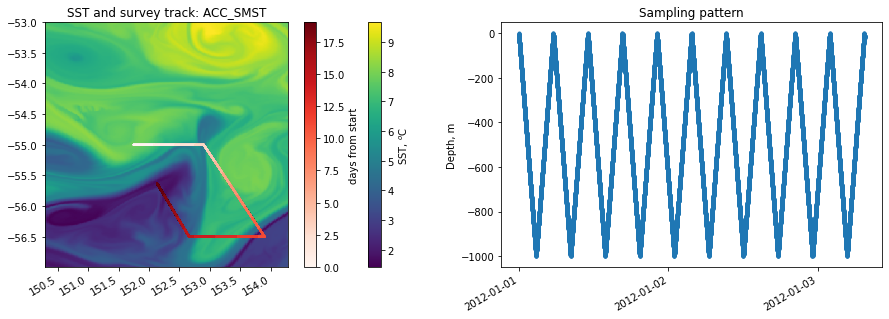

In [9]:
%matplotlib inline
plt.figure(figsize=(15,5))

# map of Theta at time zero
ax = plt.subplot(1,2,1)
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
if not (sampling_details['SAMPLING_STRATEGY'] == 'mooring' or sampling_details['SAMPLING_STRATEGY'] == 'sim_mooring'):
    tracko = plt.scatter(survey_track.lon, survey_track.lat, c=(survey_track.time-survey_track.time[0])/1e9/86400, cmap='Reds', s=0.75)
    plt.colorbar(ssto).set_label('SST, $^o$C')
    plt.colorbar(tracko).set_label('days from start')
    plt.title('SST and survey track: ' + RegionName)
else:
    plt.plot(survey_track.lon, survey_track.lat, marker='*', c='r')
    plt.title('SST and mooring location: ' + RegionName + ' region')


# depth/time plot of first few datapoints
ax = plt.subplot(1,2,2)
iplot = slice(0,20000)
if not (sampling_details['SAMPLING_STRATEGY'] == 'mooring' or sampling_details['SAMPLING_STRATEGY'] == 'sim_mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.dep.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['dep'].data.size))),
         np.tile(survey_track['dep'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
# plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Depth, m')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('Sampling pattern')


# save
if SAVE_FIGURES:
    plt.savefig('/data2/Dropbox/projects/adac/figures/' + filename_base + '_sampling.png', dpi=400, transparent=False, facecolor='white')

plt.show()


### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [10]:
%%time

del sys.modules['osse_tools'] 
from osse_tools import survey_interp, get_survey_track

subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices, sampling_details)
sgridded

Interpolating model fields to the sampling track...
saving to /data3/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_trajectory_file_2012-01-01_to_2012-01-21_maxdepth-1000_subsampled.nc
Gridding the interpolated data...


KeyError: 'SAVE_PRELIMINARY'

### Visualizations

Basic plots to show the interpolated variables

In [11]:
# 3d fields
vbls3d = ['Theta','Salt','U','V','vorticity']
vbls3d = ['Theta','Salt','vorticity']
ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig('/data2/Dropbox/projects/adac/figures/' + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


NameError: name 'sgridded' is not defined

In [ ]:
## selected 2d fields
j=0
nr = 6 # # of rows
fig,ax=plt.subplots(nr,figsize=(10,8),constrained_layout=True)


# wind vectors
ax[j].quiver(sgridded.time.data,0,sgridded.oceTAUX.data, sgridded.oceTAUY.data)
ax[j].set_title('Wind stress')    
ax[j].set_ylabel('N m-2')
# SH 
j+=1
ax[j].plot(sgridded.time,sgridded.steric_height-sgridded.steric_height.mean(), 
             sgridded.time.data,sgridded.steric_height_true-sgridded.steric_height_true.mean())
ax[j].set_title('Steric height')
ax[j].legend(['subsampled','true'])
ax[j].set_ylabel('m')

# SSH
j+=1
ax[j].plot(sgridded.time,sgridded.Eta)
ax[j].set_title('SSH')
ax[j].set_ylabel('m')

# MLD
j+=1
ax[j].plot(sgridded.time,sgridded.KPPhbl)
ax[j].set_title('MLD')
ax[j].set_ylabel('m')
ax[j].invert_yaxis()

# surface heat flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceQnet, sgridded.time,sgridded.oceQsw)
ax[j].set_title('Surface heat flux into the ocean')
ax[j].legend(['total','shortwave'])
ax[j].set_ylabel('W m-2')

# surface FW flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceFWflx)
ax[j].set_title('Surface freshwater flux into the ocean') 
ax[j].set_ylabel('kg m-2 s-1')

# horiz line:
for j in range(nr):
    ax[j].axhline(0, color='grey', linewidth=0.8)

if SAVE_FIGURES:
    plt.savefig('/data2/Dropbox/projects/adac/figures/' + filename_base + '_2D.png', dpi=400, transparent=False, facecolor='white')
   

### Save interpolated data

For both raw and gridded subsampled data, add attributes and save


In [ ]:
# add metadata to attributes
attrs = sampling_parameters
attrs['start_date'] = start_date.strftime('%Y-%m-%d')
end_date = sgridded['time'].data[-1]
attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
attrs['ndays'] = ndays
attrs.pop('DERIVED_VARIABLES')

In [ ]:
# ------ subsampled data
# this is slow and generates a huge file, so consider skipping
if sampling_parameters['SAMPLING_STRATEGY'] != 'mooring':
    filename_out = filename_out_base + '_subsampled.nc'
    print(f'saving to {filename_out}')
    subsampled_data.attrs = attrs
    netcdf_fill_value = nc4.default_fillvals['f4']
    dv_encoding={'zlib':True,  # turns compression on\
                'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                'dtype':'float32',\
                '_FillValue':netcdf_fill_value}
    # save to a new file
    # subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
    subsampled_data.to_netcdf(filename_out,format='netcdf4')
    !ls -ltrh {filename_out}

In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}

In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}


### Visualize interpolated data in 3D

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(subsampled_data.lon.data, subsampled_data.lat.data, subsampled_data.dep.data, c=subsampled_data.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')

# Testing

copied `survey_interp` from osse_tools.py

In [ ]:

        
## Create a new dataset to contain the interpolated data, and interpolate
# for 'mooring', skip this step entirely - return an empty array for 'subsampled_data'
SAMPLING_STRATEGY = survey_track['SAMPLING_STRATEGY']
if SAMPLING_STRATEGY == 'mooring':
    subsampled_data = []

    # zgridded and times are simply zs, ta (i.e., don't interpolate to a finer grid than the mooring sampling gives)
    zgridded = survey_track['dep']
    times = survey_track['time']

    # -- initialize the dataset:
    sgridded = xr.Dataset(
        coords = dict(depth=(["depth"],zgridded),
                  time=(["time"],times))
    )
    # variable names (if DERIVED_VARIABLES is not set, don't load the vector quantities)
    if survey_track['DERIVED_VARIABLES']:
        vbls3d = ['Theta','Salt','vorticity','steric_height', 'U', 'V']
        vbls2d = ['steric_height_true', 'Eta', 'KPPhbl', 'PhiBot', 'oceTAUX', 'oceTAUY', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
    else:
        vbls3d = ['Theta','Salt']
        vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']


    # loop through 3d variables & interpolate:
    for vbl in vbls3d:
        print(vbl)
        sgridded[vbl]=ds[vbl].interp(survey_indices).compute().transpose()

    # loop through 2d variables & interpolate:
    # create 2-d survey track by removing the depth dimension
    survey_indices_2d =  survey_indices.drop_vars('k')



    for vbl in vbls2d:
        print(vbl)
        sgridded[vbl]=ds[vbl].interp(survey_indices_2d).compute()


    # clean up sgridded: get rid of the dims we don't need and rename coords

    if survey_track['DERIVED_VARIABLES']:
        sgridded = sgridded.reset_coords(names = {'i', 'j', 'k'}).squeeze().rename_vars({'xav' : 'lon','yav' : 'lat'}).drop_vars(names={'i', 'j', 'k'})

        # for sampled steric height, we want the value integrated from the deepest sampling depth:
        sgridded['steric_height'] = (("time"), sgridded['steric_height'].isel(depth=int(len(zgridded))-1))
        # rename to "sampled" for clarity
        sgridded.rename_vars({'steric_height':'steric_height_sampled'})
    else:
        sgridded = sgridded.reset_coords(names = {'i', 'j', 'k'}).squeeze().drop_vars(names={'i', 'j', 'k'})

else: # not mooring
    subsampled_data = xr.Dataset(
        dict(
            t = xr.DataArray(survey_track.time, dims='points'), # call this time, for now, so that the interpolation works
            lon = xr.DataArray(survey_track.lon, dims='points'),
            lat = xr.DataArray(survey_track.lat, dims='points'),
            dep = xr.DataArray(survey_track.dep, dims='points'),
            points = xr.DataArray(survey_track.points, dims='points')
        )
    )

    # variable names (if DERIVED_VARIABLES is not set, don't load the vector quantities)
    if survey_track['DERIVED_VARIABLES']:
        vbls3d = ['Theta','Salt','vorticity','steric_height', 'U', 'V']
        vbls2d = ['steric_height_true', 'Eta', 'KPPhbl', 'PhiBot', 'oceTAUX', 'oceTAUY', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
    else:
        vbls3d = ['Theta','Salt']
        vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']


    print('Interpolating model fields to the sampling track...')
    # loop & interpolate through 3d variables:
    for vbl in vbls3d:
        subsampled_data[vbl]=ds[vbl].interp(survey_indices)



    # loop & interpolate through 2d variables:
    # create 2-d survey track by removing the depth dimension
    survey_indices_2d =  survey_indices.drop_vars('k')
    for vbl in vbls2d:
        subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)   

    # fix time, which is currently a coordinate (time) & a variable (t)
    subsampled_data = subsampled_data.reset_coords('time', drop=True).rename_vars({'t':'time'})

    # make xav and yav variables instead of coords, and rename
    if survey_track['DERIVED_VARIABLES']:
        subsampled_data = subsampled_data.reset_coords(names = {'xav','yav'}).rename_vars({'xav' : 'lon_average','yav' : 'lat_average'})

        
        
    #--- TEST ---- SAVE output
    
    # add metadata to attributes
    attrs = sampling_parameters
    attrs['start_date'] = start_date.strftime('%Y-%m-%d')
    end_date = subsampled_data['time'].data[-1]
    attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
    attrs['ndays'] = ndays
    attrs.pop('DERIVED_VARIABLES')


    filename_out = filename_out_base + '_subsampled.nc'
    print(f'saving to {filename_out}')
    subsampled_data.attrs = attrs
    netcdf_fill_value = nc4.default_fillvals['f4']
    dv_encoding={'zlib':True,  # turns compression on\
                'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                'dtype':'float32',\
                '_FillValue':netcdf_fill_value}
    # save to a new file
    # subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
    subsampled_data.to_netcdf(filename_out,format='netcdf4')
    !ls -ltrh {filename_out}
    
    
    

In [ ]:
subsampled_data

In [ ]:
# now, reload with no chunking/dask and do the regridding
subsampled_data = xr.open_dataset(filename_out)
subsampled_data

In [ ]:
%%time
# ------Regrid the data to depth/time (3-d fields) or subsample to time (2-d fields)
print('Gridding the interpolated data...')


# get times associated with profiles:
if SAMPLING_STRATEGY == 'sim_mooring':
    # - for mooring, use the subsampled time grid:
    times = np.unique(subsampled_data.time.values)
else:
    # -- for glider/uctd, take the shallowest & deepest profiles (every second value, since top/bottom get sampled twice for each profile)
    time_deepest = subsampled_data.time.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True).values[0:-1:2]
    time_shallowest = subsampled_data.time.where(subsampled_data.dep == subsampled_data.dep.max(), drop=True).values[0:-1:2]
    times = np.sort(np.concatenate((time_shallowest, time_deepest)))
    # this results in a time grid that may not be uniformly spaced, but is correct
    # - for a uniform grid, use the mean time spacing - may not be perfectly accurate, but is evenly spaced
    dt = np.mean(np.diff(time_shallowest))/2 # average spacing of profiles (half of one up/down, so divide by two)
    times_uniform = np.arange(survey_track.n_profiles.values*2) * dt

# nt is the number of profiles (times):
nt = len(times)  
# xgr is the vertical grid; nz is the number of depths for each profile
# depths are negative, so sort in reverse order using flip
zgridded = np.flip(np.unique(subsampled_data.dep.data))
nz = int(len(zgridded))

# -- initialize the dataset:
sgridded = xr.Dataset(
    coords = dict(depth=(["depth"],zgridded),
              time=(["time"],times))
)
# -- 3-d fields: loop & reshape 3-d data from profiles to a 2-d (depth-time) grid:
# first, extract each variable, then reshape to a grid

for vbl in vbls3d:
    print(vbl)
    this_var = subsampled_data[vbl].data.copy() 
    # reshape to nz,nt
    this_var_reshape = np.reshape(this_var,(nz,nt), order='F') # fortran order is important!
    # for platforms with up & down profiles (uCTD and glider),
    # every second column is upside-down (upcast data)
    # starting with the first column, flip the data upside down so that upcasts go from top to bottom
    if SAMPLING_STRATEGY != 'sim_mooring':
        this_var_fix = this_var_reshape.copy()
        #this_var_fix[:,0::2] = this_var_fix[-1::-1,0::2] 
        this_var_fix[:,1::2] = this_var_fix[-1::-1,1::2]  # Starting with SECOND column
        sgridded[vbl] = (("depth","time"), this_var_fix)
    elif SAMPLING_STRATEGY == 'sim_mooring':
        sgridded[vbl] = (("depth","time"), this_var_reshape)


# for sampled steric height, we want the value integrated from the deepest sampling depth:
sgridded['steric_height'] = (("time"), sgridded['steric_height'].isel(depth=nz-1).data)
# rename to "steric_height_sampled" for clarity
sgridded.rename_vars({'steric_height':'steric_height_sampled'})



#  -- 2-d fields: loop & reshape 2-d data to the same time grid 
for vbl in vbls2d:
    this_var = subsampled_data[vbl].data.copy() 
    # subsample to nt
    this_var_sub = this_var[0:-1:nz]
    sgridded[vbl] = (("time"), this_var_sub)

# # ------------ RETURN INTERPOLATED & GRIDDED DATA ------------

# # -- add variable attributes from ds
# if SAMPLING_STRATEGY == 'mooring':
# sgridded.attrs = ds.attrs
# else:
# # - find which variables in ds are also in our interpolated dataset:
# vars_ds = list(ds.keys())
# vars_sdata = list(subsampled_data.keys())
# vars_both = list(set(vars_ds) & set(vars_sdata))
# for var in vars_both:
#     # copy over the attribute from ds:
#     subsampled_data[var].attrs = ds[var].attrs
#     sgridded[var].attrs = ds[var].attrs





In [ ]:
sgridded.Theta.plot()